In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [5]:
import math

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [7]:
import random

## Constants

In [8]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get paths of files

In [9]:
base_file_dict = defaultdict(list)
credit_bureau_a_1_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'credit_bureau_a_1' in file_path:
                credit_bureau_a_1_file_dict[file_type].append(file_path)

In [10]:
credit_bureau_a_1_file_dict.get("train")

['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_0.parquet',
 '/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_1.parquet',
 '/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_3.parquet',
 '/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_credit_bureau_a_1_2.parquet']

## Functions

In [11]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [12]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [13]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [14]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column, order=df.sort_values(by=[percent_column], ascending=False)[category_column].values)
    return fig

In [15]:
def get_relevant_indices(series):
    percentile_25 = series.quantile(0.25)
    percentile_75 = series.quantile(0.75)
    iqr = percentile_75-percentile_25
    upper_limit = percentile_75 + 1.5*iqr
    lower_limit = percentile_25 - 1.5*iqr

    keep_indices = series[(series>=lower_limit) & (series<=upper_limit)].index
    return keep_indices 

In [16]:
def most_common_value(series,ignore_category=None):
    counter_dict = Counter(series)
    most_common_category_list = counter_dict.most_common()
    most_common_category_list_length = len(most_common_category_list)
    if (most_common_category_list_length == 0) or (most_common_category_list_length == 1):
        if most_common_category_list[0][0] == ignore_category:
            return np.nan
        else:
            return most_common_category_list[0][0]
    else:
        #print(most_common_category_list_length)
        most_common_category = most_common_category_list[0][0]
        second_most_common_category = most_common_category_list[1][0]

        if most_common_category == ignore_category:
            return second_most_common_category
        else:
            return most_common_category

## Read datasets

In [17]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


In [18]:
train_base_df = pd.concat([pd.read_parquet(file_path) for file_path in base_file_dict['train']], axis=0)
print(f"Shape of train_base_df: {train_base_df.shape}")

Shape of train_base_df: (1526659, 5)


## Properties: depth=1, external data source

In [19]:
credit_bureau_a_1_df = pd.concat([pd.read_parquet(file_path) for file_path in credit_bureau_a_1_file_dict['train']], axis=0).reset_index(drop=True)
print(f"Shape of credit_bureau_a_1_df: {credit_bureau_a_1_df.shape}")

Shape of credit_bureau_a_1_df: (15940537, 79)


In [20]:
credit_bureau_a_1_df.columns.unique()

Index(['case_id', 'annualeffectiverate_199L', 'annualeffectiverate_63L',
       'classificationofcontr_13M', 'classificationofcontr_400M',
       'contractst_545M', 'contractst_964M', 'contractsum_5085717L',
       'credlmt_230A', 'credlmt_935A', 'dateofcredend_289D',
       'dateofcredend_353D', 'dateofcredstart_181D', 'dateofcredstart_739D',
       'dateofrealrepmt_138D', 'debtoutstand_525A', 'debtoverdue_47A',
       'description_351M', 'dpdmax_139P', 'dpdmax_757P',
       'dpdmaxdatemonth_442T', 'dpdmaxdatemonth_89T', 'dpdmaxdateyear_596T',
       'dpdmaxdateyear_896T', 'financialinstitution_382M',
       'financialinstitution_591M', 'instlamount_768A', 'instlamount_852A',
       'interestrate_508L', 'lastupdate_1112D', 'lastupdate_388D',
       'monthlyinstlamount_332A', 'monthlyinstlamount_674A',
       'nominalrate_281L', 'nominalrate_498L', 'num_group1',
       'numberofcontrsvalue_258L', 'numberofcontrsvalue_358L',
       'numberofinstls_229L', 'numberofinstls_320L',
       'n

In [21]:
train_base_df["date_decision"] = pd.to_datetime(train_base_df["date_decision"])
credit_bureau_a_1_df["dateofcredend_289D"] = pd.to_datetime(credit_bureau_a_1_df["dateofcredend_289D"])
credit_bureau_a_1_df["dateofcredend_353D"] = pd.to_datetime(credit_bureau_a_1_df["dateofcredend_353D"])
credit_bureau_a_1_df["dateofcredstart_181D"] = pd.to_datetime(credit_bureau_a_1_df["dateofcredstart_181D"])
credit_bureau_a_1_df["dateofcredstart_739D"] = pd.to_datetime(credit_bureau_a_1_df["dateofcredstart_739D"])
credit_bureau_a_1_df["dateofrealrepmt_138D"] = pd.to_datetime(credit_bureau_a_1_df["dateofrealrepmt_138D"])
credit_bureau_a_1_df["refreshdate_3813885D"] = pd.to_datetime(credit_bureau_a_1_df["refreshdate_3813885D"])
credit_bureau_a_1_df["dateofrealrepmt_138D"] = pd.to_datetime(credit_bureau_a_1_df["dateofrealrepmt_138D"])

In [136]:
date_column_list = ["dateofcredend_289D", "dateofcredend_353D", "dateofcredstart_181D", "dateofcredstart_739D", "dateofrealrepmt_138D", "refreshdate_3813885D", "dateofrealrepmt_138D"]
for col in date_column_list:
    credit_bureau_a_1_df.loc[credit_bureau_a_1_df[col].dt.year.isin([1900, 2098]), col] = np.datetime64('NaT')

In [137]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"])[["case_id", "num_group1", "dateofcredend_289D", "dateofcredend_353D", "dateofcredstart_181D", "dateofcredstart_739D", "dateofrealrepmt_138D", "refreshdate_3813885D"]]

,case_id,num_group1,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,refreshdate_3813885D
11747397,1929311,0,2021-05-24,2018-05-04,2017-04-14,2013-05-24,2018-05-03,2020-09-29
11747398,1929311,1,NaT,2019-09-03,2019-06-03,NaT,2019-09-03,2020-09-29
11747399,1929311,2,NaT,NaT,NaT,NaT,NaT,2020-09-29
11747400,1929311,3,NaT,NaT,NaT,NaT,NaT,NaT
11747401,1929311,4,NaT,NaT,NaT,NaT,NaT,2019-01-03
11747402,1929311,5,NaT,NaT,NaT,NaT,NaT,2020-09-24
11747403,1929311,6,NaT,NaT,NaT,NaT,NaT,2019-11-03
11747404,1929311,7,NaT,NaT,NaT,NaT,NaT,2020-04-16
11747405,1929311,8,NaT,NaT,NaT,NaT,NaT,2020-08-17


## This means that there are multiple rows for each case_id indexed by num_group1

In [138]:
unique_num_group_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"num_group1": "nunique"}).reset_index().rename({"num_group1": "generated_count_of_credit_information_by_a"}, axis=1)

In [139]:
unique_num_group_case_id_df[unique_num_group_case_id_df.generated_count_of_credit_information_by_a>10].sort_values(by=["generated_count_of_credit_information_by_a"]).head(5)

,case_id,generated_count_of_credit_information_by_a
0,388,11
1202898,1923877,11
584098,1292778,11
584097,1292777,11
1202900,1923879,11


<Axes: ylabel='generated_count_of_credit_information_by_a'>

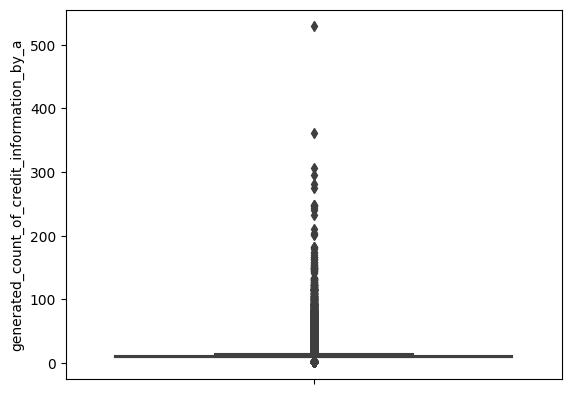

In [140]:
sns.boxplot(data=unique_num_group_case_id_df, y="generated_count_of_credit_information_by_a")

In [141]:
unique_num_group_case_id_df.generated_count_of_credit_information_by_a.describe()

count    1.386273e+06
mean     1.149884e+01
std      4.969215e+00
min      1.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.100000e+01
max      5.290000e+02
Name: generated_count_of_credit_information_by_a, dtype: float64

## Count of credit records by provider a varies from 1 to 529

## 1. dateofcredstart_181D and dateofcredstart_739D

In [142]:
get_column_description(feature_df, "dateofcredstart_181D")

'Date when the credit contract was closed.'

In [143]:
get_column_description(feature_df, "dateofcredstart_739D")

'Start date of a closed credit contract.'

In [144]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"])[["case_id", "num_group1", "dateofcredstart_181D", "dateofcredstart_739D"]]

,case_id,num_group1,dateofcredstart_181D,dateofcredstart_739D
5526150,805547,0,NaT,2011-10-19
5526151,805547,1,NaT,NaT
5526152,805547,2,NaT,NaT
5526153,805547,3,NaT,NaT
5526154,805547,4,NaT,NaT
5526155,805547,5,NaT,NaT
5526156,805547,6,NaT,NaT
5526157,805547,7,NaT,NaT
5526158,805547,8,NaT,NaT


In [145]:
not_null_dateofcredstart_df = credit_bureau_a_1_df[~credit_bureau_a_1_df.dateofcredstart_181D.isnull() & ~credit_bureau_a_1_df.dateofcredstart_739D.isnull()]

In [146]:
(not_null_dateofcredstart_df["dateofcredstart_181D"]<=not_null_dateofcredstart_df["dateofcredstart_739D"]).value_counts()

True     1689905
False     141624
Name: count, dtype: int64

In [147]:
not_null_dateofcredstart_df[not_null_dateofcredstart_df["dateofcredstart_181D"]>not_null_dateofcredstart_df["dateofcredstart_739D"]][["case_id", "num_group1", "dateofcredstart_181D", "dateofcredstart_739D"]].head()

,case_id,num_group1,dateofcredstart_181D,dateofcredstart_739D
52214,7233,0,2015-03-25,2014-08-06
53913,7429,0,2016-12-05,2014-01-08
55695,7654,0,2018-07-17,2014-09-13
56275,7731,0,2016-01-01,2014-05-19
57536,7893,0,2018-01-26,2016-09-14


## I do not understand the meaning of dateofcredstart_181D, dateofcredstart_739D

## 2. dateofcredend_289D and dateofcredend_353D

In [148]:
get_column_description(feature_df, "dateofcredend_289D")

'End date of an active credit contract.'

In [149]:
get_column_description(feature_df, "dateofcredend_353D")

'End date of a closed credit contract.'

In [150]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"])[["case_id", "num_group1", "dateofcredstart_739D", "dateofcredstart_181D", "dateofcredend_353D", "dateofcredend_289D"]]

,case_id,num_group1,dateofcredstart_739D,dateofcredstart_181D,dateofcredend_353D,dateofcredend_289D
1206111,684577,0,2015-01-04,NaT,NaT,2021-01-04
1206112,684577,1,NaT,NaT,NaT,NaT
1206113,684577,2,NaT,NaT,NaT,NaT
1206114,684577,3,NaT,NaT,NaT,NaT
1206115,684577,4,NaT,NaT,NaT,NaT
1206116,684577,5,NaT,NaT,NaT,NaT
1206117,684577,6,NaT,NaT,NaT,NaT
1206118,684577,7,NaT,NaT,NaT,NaT
1206119,684577,8,NaT,NaT,NaT,NaT
1206120,684577,9,NaT,NaT,NaT,NaT


In [151]:
credit_bureau_a_1_df[~credit_bureau_a_1_df.dateofcredstart_739D.isnull() & ~credit_bureau_a_1_df.dateofcredend_289D.isnull()][["case_id", "num_group1", "dateofcredstart_739D", "dateofcredstart_181D", "dateofcredend_353D", "dateofcredend_289D"]]

,case_id,num_group1,dateofcredstart_739D,dateofcredstart_181D,dateofcredend_353D,dateofcredend_289D
0,388,1,2018-08-06,NaT,NaT,2020-08-06
1,388,0,2018-06-20,NaT,NaT,2023-06-20
11,405,0,2012-06-06,NaT,NaT,2020-06-06
12,405,1,2017-11-06,NaT,NaT,2022-11-06
22,409,2,2018-11-25,NaT,NaT,2019-02-25
...,...,...,...,...,...,...
15940460,2683572,0,2019-10-21,2016-10-08,2019-10-08,2023-10-21
15940490,2683574,0,2019-10-16,2006-06-14,2007-09-14,2034-10-16
15940501,2683575,0,2018-11-12,NaT,NaT,2020-11-11
15940510,2683576,0,2013-03-13,2016-03-27,2017-09-27,2021-03-13


## It appears that dateofcredstart_181D and dateofcredend_353D are paired together => CLOSED CONTRACT START AND END DATE

In [152]:
not_null_dateofcredstart_181D_and_dateofcredend_353D_df = credit_bureau_a_1_df[~credit_bureau_a_1_df.dateofcredstart_181D.isnull() & ~credit_bureau_a_1_df.dateofcredend_353D.isnull()]

In [153]:
(not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredend_353D"] - not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredstart_181D"]).dt.days

51613        179
51614        359
51615       1096
51616        365
51617        731
            ... 
15940519     242
15940520     358
15940521     175
15940528     365
15940529     182
Length: 6751578, dtype: int64

In [154]:
(not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredstart_181D"]<=not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredend_353D"]).value_counts()

True     6751391
False        187
Name: count, dtype: int64

In [155]:
not_null_dateofcredstart_181D_and_dateofcredend_353D_df[~(not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredstart_181D"]<=not_null_dateofcredstart_181D_and_dateofcredend_353D_df["dateofcredend_353D"])]["dateofcredstart_181D"].dt.to_period('Y').value_counts()

dateofcredstart_181D
2012    107
2008     48
2009     15
2013      5
2006      3
2010      3
2007      3
2001      2
2016      1
Freq: A-DEC, Name: count, dtype: int64

## Ignore cases where dateofcredstart_181D<dateofcredend_353D

## Calcuate duration of credit contract using dateofcredstart_181D and dateofcredend_353D

In [156]:
credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_closed_contract"] = (credit_bureau_a_1_df["dateofcredend_353D"]-credit_bureau_a_1_df["dateofcredstart_181D"])/np.timedelta64(1, 'M')
credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_closed_contract"] = credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_closed_contract"].apply(lambda x: np.nan if pd.isna(x) else math.ceil(x))
credit_bureau_a_1_df.loc[credit_bureau_a_1_df.month_lapse_between_start_and_end_date_of_closed_contract <0, "month_lapse_between_start_and_end_date_of_closed_contract"] = np.nan

<Axes: ylabel='month_lapse_between_start_and_end_date_of_closed_contract'>

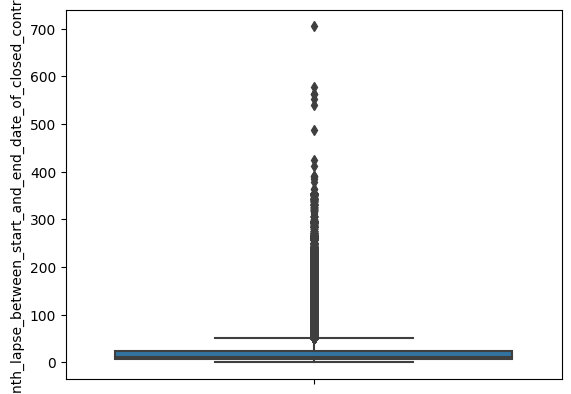

In [157]:
sns.boxplot(data=credit_bureau_a_1_df, y="month_lapse_between_start_and_end_date_of_closed_contract")

In [158]:
statistics_month_lapse_between_start_and_end_date_of_closed_contract_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"month_lapse_between_start_and_end_date_of_closed_contract": ["max", "min", "mean", "count"]}).reset_index()
statistics_month_lapse_between_start_and_end_date_of_closed_contract_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_month_lapse_between_start_and_end_date_of_closed_contract_df.columns]

In [159]:
merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df = train_base_df.merge(statistics_month_lapse_between_start_and_end_date_of_closed_contract_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df: {merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df.shape}")

Shape of merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df: (1526659, 9)


<Axes: xlabel='target', ylabel='generated_month_lapse_between_start_and_end_date_of_closed_contract_max'>

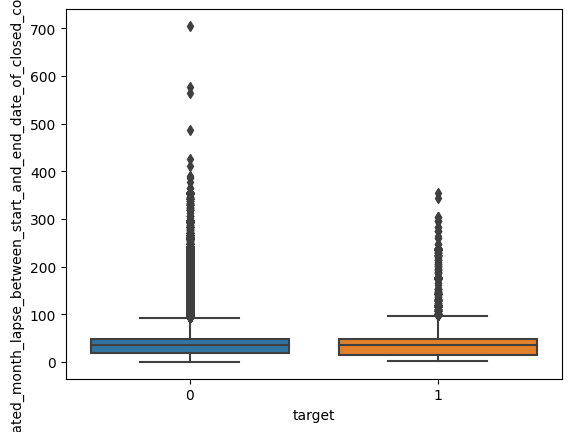

In [160]:
sns.boxplot(data=merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df, y="generated_month_lapse_between_start_and_end_date_of_closed_contract_max", x="target")

<Axes: xlabel='target', ylabel='generated_month_lapse_between_start_and_end_date_of_closed_contract_mean'>

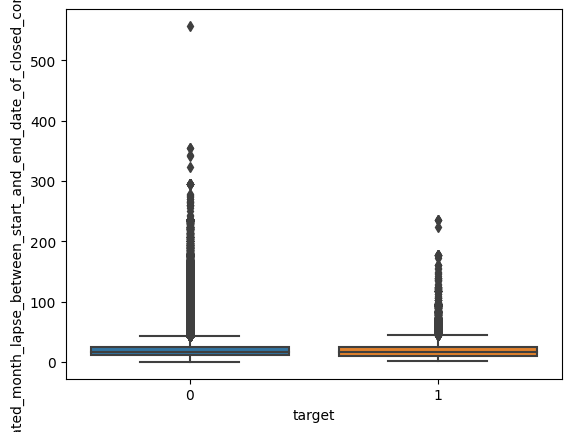

In [161]:
sns.boxplot(data=merged_train_base_statistics_month_lapse_between_start_and_end_date_of_closed_contract_for_case_id_df, y="generated_month_lapse_between_start_and_end_date_of_closed_contract_mean", x="target")

## target=1 have shorter duration of CLOSED credict contracts.

## 3. dateofcredstart_739D and dateofcredend_289D 

In [162]:
not_null_dateofcredstart_739D_and_dateofcredend_289D_df = credit_bureau_a_1_df[~credit_bureau_a_1_df.dateofcredstart_739D.isnull() & ~credit_bureau_a_1_df.dateofcredend_289D.isnull()]

In [163]:
(not_null_dateofcredstart_739D_and_dateofcredend_289D_df["dateofcredstart_739D"]<=not_null_dateofcredstart_739D_and_dateofcredend_289D_df["dateofcredend_289D"]).value_counts()

True    2659270
Name: count, dtype: int64

## All cases have dateofcredstart_739D<=dateofcredend_289D

## Calcuate duration of credit contract using dateofcredstart_739D and dateofcredend_289D

In [164]:
credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_active_contract"] = (credit_bureau_a_1_df["dateofcredend_289D"]-credit_bureau_a_1_df["dateofcredstart_739D"])/np.timedelta64(1, 'M')
credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_active_contract"] = credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_active_contract"].apply(lambda x: np.nan if pd.isna(x) else math.ceil(x))
credit_bureau_a_1_df.loc[credit_bureau_a_1_df.month_lapse_between_start_and_end_date_of_active_contract <0, "month_lapse_between_start_and_end_date_of_active_contract"] = np.nan

<Axes: ylabel='month_lapse_between_start_and_end_date_of_active_contract'>

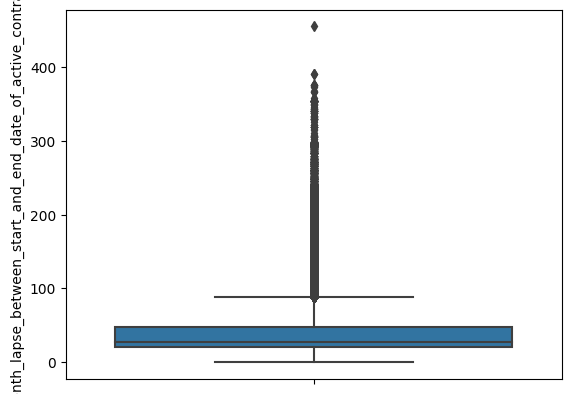

In [165]:
sns.boxplot(data=credit_bureau_a_1_df, y="month_lapse_between_start_and_end_date_of_active_contract")

In [166]:
statistics_month_lapse_between_start_and_end_date_of_active_contract_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"month_lapse_between_start_and_end_date_of_active_contract": ["max", "min", "mean", "count"]}).reset_index()
statistics_month_lapse_between_start_and_end_date_of_active_contract_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_month_lapse_between_start_and_end_date_of_active_contract_df.columns]

In [167]:
merged_train_base_statistics_month_lapse_between_start_and_end_date_of_active_contract_for_case_id_df = train_base_df.merge(statistics_month_lapse_between_start_and_end_date_of_active_contract_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_month_lapse_between_start_and_end_date_of_active_contract_for_case_id_df: {merged_train_base_statistics_month_lapse_between_start_and_end_date_of_active_contract_for_case_id_df.shape}")

Shape of merged_train_base_statistics_month_lapse_between_start_and_end_date_of_active_contract_for_case_id_df: (1526659, 9)


<Axes: xlabel='target', ylabel='generated_month_lapse_between_start_and_end_date_of_active_contract_max'>

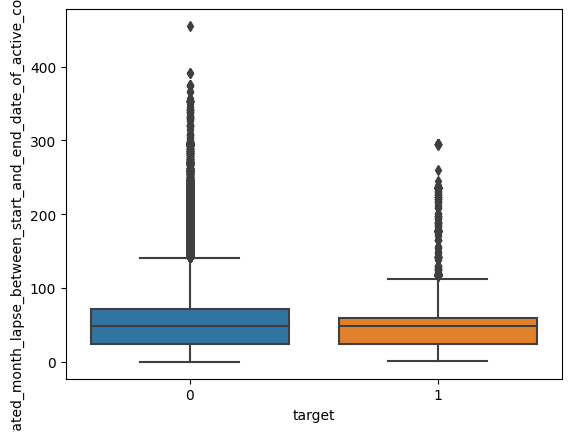

In [168]:
sns.boxplot(data=merged_train_base_statistics_month_lapse_between_start_and_end_date_of_active_contract_for_case_id_df, y="generated_month_lapse_between_start_and_end_date_of_active_contract_max", x="target")

## target=1 have shorter duration of ACTIVE credict contracts.

In [169]:
## Get number of active and closed contracts for each case_id
credit_bureau_a_1_df["generated_has_closed_contract"] = np.where((~credit_bureau_a_1_df["dateofcredend_353D"].isnull()) & (~credit_bureau_a_1_df["dateofcredstart_181D"].isnull()) & (credit_bureau_a_1_df["dateofcredend_353D"]>=credit_bureau_a_1_df["dateofcredstart_181D"]), 1, 0)
credit_bureau_a_1_df["generated_has_active_contract"] = np.where((~credit_bureau_a_1_df["dateofcredend_289D"].isnull()) & (~credit_bureau_a_1_df["dateofcredstart_739D"].isnull()) & (credit_bureau_a_1_df["dateofcredend_289D"]>=credit_bureau_a_1_df["dateofcredstart_739D"]), 1, 0)

In [170]:
credit_bureau_a_1_df["generated_number_of_contracts"] = credit_bureau_a_1_df["generated_has_closed_contract"] + credit_bureau_a_1_df["generated_has_active_contract"]

In [171]:
statistics_number_of_contracts_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"generated_number_of_contracts": ["count"]}).reset_index()
statistics_number_of_contracts_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_number_of_contracts_df.columns]

In [172]:
merged_train_base_statistics_number_of_contracts_df = train_base_df.merge(statistics_number_of_contracts_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_number_of_contracts_df: {merged_train_base_statistics_number_of_contracts_df.shape}")

Shape of merged_train_base_statistics_number_of_contracts_df: (1526659, 6)


<Axes: xlabel='target', ylabel='generated_generated_number_of_contracts_count'>

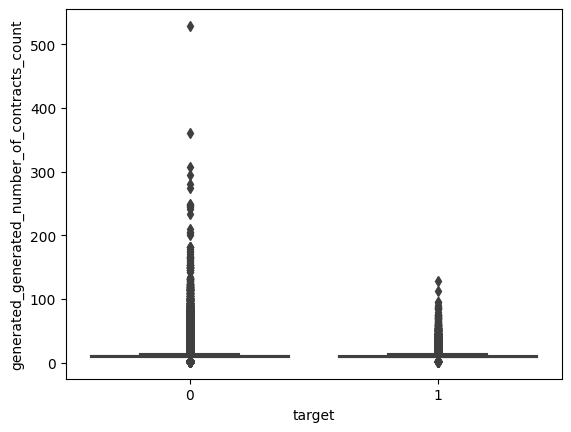

In [173]:
sns.boxplot(data=merged_train_base_statistics_number_of_contracts_df, y="generated_generated_number_of_contracts_count", x="target")

## Number of contracts higher for target=0

## 4. annualeffectiverate_199L and annualeffectiverate_63L 

In [174]:
get_column_description(feature_df, "annualeffectiverate_199L")

'Interest rate of the closed contracts.'

In [175]:
credit_bureau_a_1_df.annualeffectiverate_199L.isnull().value_counts()

annualeffectiverate_199L
True     15213904
False      726633
Name: count, dtype: int64

In [176]:
get_column_description(feature_df, "annualeffectiverate_63L")

'Interest rate for the active contracts.'

In [177]:
credit_bureau_a_1_df.annualeffectiverate_63L.isnull().value_counts()

annualeffectiverate_63L
True     15629294
False      311243
Name: count, dtype: int64

In [178]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"])[["case_id", "num_group1", "generated_has_active_contract", "dateofcredstart_739D", "dateofcredend_289D", "annualeffectiverate_63L"]]

,case_id,num_group1,generated_has_active_contract,dateofcredstart_739D,dateofcredend_289D,annualeffectiverate_63L
13149413,936684,0,1,2017-07-26,2021-07-26,NaN
13149414,936684,1,1,2015-03-19,2020-02-24,NaN
13149412,936684,2,1,2019-11-04,2022-11-04,18.82
13149415,936684,3,0,NaT,NaT,NaN
13149416,936684,4,0,NaT,NaT,NaN
13149417,936684,5,0,NaT,NaT,NaN
13149418,936684,6,0,NaT,NaT,NaN
13149419,936684,7,0,NaT,NaT,NaN
13149420,936684,8,0,NaT,NaT,NaN


## 5. classificationofcontr_13M, classificationofcontr_400M , contractst_545M, contractst_964M

In [179]:
get_column_description(feature_df, "classificationofcontr_13M")

'Classificiation of the active contract.'

In [180]:
credit_bureau_a_1_df.classificationofcontr_13M.isnull().value_counts()

classificationofcontr_13M
False    15940537
Name: count, dtype: int64

In [181]:
credit_bureau_a_1_df.classificationofcontr_13M.value_counts()

classificationofcontr_13M
a55475b1    13283816
ea6782cc     2305054
01f63ac8      226675
00135d9c       82598
4408ff0f       38248
be7b251d        1834
1cf4e481        1506
2c070815         460
87bdbcba         199
4a5a01e3         139
0d95a828           8
Name: count, dtype: int64

In [182]:
get_column_description(feature_df, "classificationofcontr_400M")

'Classificiation of the closed contract.'

In [183]:
credit_bureau_a_1_df.classificationofcontr_400M.isnull().value_counts()

classificationofcontr_400M
False    15940537
Name: count, dtype: int64

In [184]:
credit_bureau_a_1_df.classificationofcontr_400M.value_counts()

classificationofcontr_400M
a55475b1    9199492
ea6782cc    4113204
01f63ac8     987176
00135d9c     399620
42a42e75     173049
             ...   
7e90d519          1
2d45fbaa          1
9d1e605e          1
4b2a1f69          1
8bd853b1          1
Name: count, Length: 389, dtype: int64

In [185]:
get_column_description(feature_df, "contractst_545M")

'Contract status.'

In [186]:
credit_bureau_a_1_df.contractst_545M.isnull().value_counts()

contractst_545M
False    15940537
Name: count, dtype: int64

In [187]:
credit_bureau_a_1_df.contractst_545M.value_counts().head(5)

contractst_545M
a55475b1    13288714
7241344e     2569115
8f3a197f       23875
0dc85f9d       19963
dd67cff0        7463
Name: count, dtype: int64

In [188]:
get_column_description(feature_df, "contractst_964M")

'Contract status of terminated credit contract.'

In [189]:
credit_bureau_a_1_df.contractst_964M.value_counts().head(5)

contractst_964M
a55475b1    9190981
7241344e    6323407
8f3a197f     107817
a3386307      57211
8260bab9      43586
Name: count, dtype: int64

In [270]:

credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"], ascending=True)[["case_id", "num_group1", "generated_has_active_contract", "dateofcredstart_739D", "dateofcredend_289D", "annualeffectiverate_63L", "classificationofcontr_13M", "contractst_545M", "generated_has_closed_contract", "dateofcredstart_181D", "dateofcredend_353D", "annualeffectiverate_199L",  "classificationofcontr_400M", "contractst_964M", "debtoutstand_525A", "description_351M"]]

,case_id,num_group1,generated_has_active_contract,dateofcredstart_739D,dateofcredend_289D,annualeffectiverate_63L,classificationofcontr_13M,contractst_545M,generated_has_closed_contract,dateofcredstart_181D,dateofcredend_353D,annualeffectiverate_199L,classificationofcontr_400M,contractst_964M,debtoutstand_525A,description_351M
5201634,765044,0,1,2017-08-04,2021-08-04,NaN,ea6782cc,7241344e,0,NaT,NaT,NaN,a55475b1,a55475b1,40034.402,a55475b1
5201633,765044,1,1,2019-06-11,2022-06-11,NaN,ea6782cc,7241344e,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201635,765044,2,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201636,765044,3,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201637,765044,4,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201638,765044,5,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201639,765044,6,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201640,765044,7,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1
5201641,765044,8,0,NaT,NaT,NaN,a55475b1,a55475b1,0,NaT,NaT,NaN,a55475b1,a55475b1,NaN,a55475b1


## Get most common classificationofcontr_13M and classificationofcontr_400M ignoring a55475b1

In [191]:
statistics_classificationofcontr_13M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_classificationofcontr_13M_nunique=pd.NamedAgg(column="classificationofcontr_13M", aggfunc="nunique"), generated_classificationofcontr_13M_mode=pd.NamedAgg(column="classificationofcontr_13M", aggfunc=lambda x:most_common_value(x, ignore_category="a55475b1")))

In [192]:
statistics_classificationofcontr_13M_for_case_id_df.head()

,generated_classificationofcontr_13M_nunique,generated_classificationofcontr_13M_mode
case_id,,
388,3,ea6782cc
405,3,ea6782cc
409,2,ea6782cc
410,2,ea6782cc
411,3,01f63ac8


In [193]:
statistics_classificationofcontr_400M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_classificationofcontr_400M_nunique=pd.NamedAgg(column="classificationofcontr_400M", aggfunc="nunique"), generated_classificationofcontr_400M_mode=pd.NamedAgg(column="classificationofcontr_400M", aggfunc=lambda x:most_common_value(x, ignore_category="a55475b1")))

In [194]:
statistics_classificationofcontr_400M_for_case_id_df.tail()

,generated_classificationofcontr_400M_nunique,generated_classificationofcontr_400M_mode
case_id,,
2703450,4,ea6782cc
2703451,2,ea6782cc
2703452,2,ea6782cc
2703453,4,ea6782cc
2703454,4,00135d9c


## Get most common contractst_545M and contractst_964M ignoring a55475b1

In [195]:
statistics_contractst_545M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_contractst_545M_nunique=pd.NamedAgg(column="contractst_545M", aggfunc="nunique"), generated_contractst_545M_mode=pd.NamedAgg(column="contractst_545M", aggfunc=lambda x:most_common_value(x, ignore_category="a55475b1")))

In [196]:
statistics_contractst_545M_for_case_id_df.tail()

,generated_contractst_545M_nunique,generated_contractst_545M_mode
case_id,,
2703450,2,7241344e
2703451,2,7241344e
2703452,2,7241344e
2703453,2,7241344e
2703454,2,7241344e


In [197]:
statistics_contractst_964M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_contractst_964M_nunique=pd.NamedAgg(column="contractst_964M", aggfunc="nunique"), generated_contractst_964M_mode=pd.NamedAgg(column="contractst_964M", aggfunc=lambda x:most_common_value(x, ignore_category="a55475b1")))

In [198]:
statistics_contractst_964M_for_case_id_df.tail()

,generated_contractst_964M_nunique,generated_contractst_964M_mode
case_id,,
2703450,2,7241344e
2703451,2,7241344e
2703452,2,7241344e
2703453,2,7241344e
2703454,2,7241344e


## 6. contractsum_5085717L

In [199]:
get_column_description(feature_df, "contractsum_5085717L")

'Sum of other contract values.'

## 6. credlmt_230A and credlmt_935A

In [200]:
get_column_description(feature_df, "credlmt_230A")

'Credit limit of the closed credit contracts from credit bureau.'

In [201]:
get_column_description(feature_df, "credlmt_935A")

'Credit limit for active loan.'

In [202]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"], ascending=True)[["case_id", "num_group1", "generated_has_active_contract", "month_lapse_between_start_and_end_date_of_active_contract", "dateofcredstart_739D", "dateofcredend_289D", "credlmt_935A", "generated_has_closed_contract", "month_lapse_between_start_and_end_date_of_closed_contract", "dateofcredstart_181D", "dateofcredend_353D", "credlmt_230A"]]

,case_id,num_group1,generated_has_active_contract,month_lapse_between_start_and_end_date_of_active_contract,dateofcredstart_739D,dateofcredend_289D,credlmt_935A,generated_has_closed_contract,month_lapse_between_start_and_end_date_of_closed_contract,dateofcredstart_181D,dateofcredend_353D,credlmt_230A
13098860,930466,0,1,71.0,2015-06-11,2021-06-11,0.0,1,59.0,2006-01-11,2011-01-10,NaN
13098859,930466,1,0,NaN,NaT,NaT,NaN,1,24.0,2012-11-28,2014-11-28,6000.0
13098861,930466,2,0,NaN,NaT,NaT,NaN,1,6.0,2013-05-31,2013-12-01,NaN
13098857,930466,3,0,NaN,NaT,NaT,NaN,1,12.0,2018-03-03,2019-03-05,NaN
13098854,930466,4,0,NaN,NaT,NaT,NaN,1,12.0,2018-07-30,2019-07-30,NaN
13098855,930466,5,0,NaN,NaT,NaT,NaN,1,10.0,2018-12-26,2019-10-26,NaN
13098856,930466,6,0,NaN,NaT,NaT,NaN,1,12.0,2019-09-05,2020-09-05,NaN
13098858,930466,7,0,NaN,NaT,NaT,NaN,1,2.0,2019-09-05,2019-10-09,0.0
13098862,930466,8,0,NaN,NaT,NaT,NaN,0,NaN,NaT,NaT,NaN


In [203]:
credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_max_credit_limit_for_active_contract=pd.NamedAgg(column="credlmt_935A", aggfunc="max"), generated_max_credit_limit_for_closed_contract=pd.NamedAgg(column="credlmt_230A", aggfunc="max"))

,generated_max_credit_limit_for_active_contract,generated_max_credit_limit_for_closed_contract
case_id,,
388,135806.0,NaN
405,0.0,NaN
409,NaN,NaN
410,0.0,NaN
411,160000.0,NaN
...,...,...
2703450,NaN,20600.0
2703451,NaN,NaN
2703452,53000.0,4000.0


## 7. dateofrealrepmt_138D

In [204]:
get_column_description(feature_df, "dateofrealrepmt_138D")

"Date of credit's closure (contract termination date)."

In [205]:
credit_bureau_a_1_df.loc[credit_bureau_a_1_df.generated_has_closed_contract == 1, "generated_closed_contract_end_type"] = "on_end_date"
credit_bureau_a_1_df.loc[(credit_bureau_a_1_df.generated_has_closed_contract == 1) & (credit_bureau_a_1_df["dateofrealrepmt_138D"]<credit_bureau_a_1_df["dateofcredend_353D"]), "generated_closed_contract_end_type"] = "before_end_date"
credit_bureau_a_1_df.loc[(credit_bureau_a_1_df.generated_has_closed_contract == 1) & (credit_bureau_a_1_df["dateofrealrepmt_138D"]>credit_bureau_a_1_df["dateofcredend_353D"]), "generated_closed_contract_end_type"] = "after_end_date"

In [206]:
credit_bureau_a_1_df.generated_closed_contract_end_type.value_counts()

generated_closed_contract_end_type
before_end_date    3317682
after_end_date     1806575
on_end_date        1627935
Name: count, dtype: int64

In [207]:
credit_bureau_a_1_df["generated_days_lapse_between_real_end_and_stated_end_closed_contract"] = np.nan
credit_bureau_a_1_df.loc[(credit_bureau_a_1_df.generated_has_closed_contract == 1) & (credit_bureau_a_1_df.dateofcredstart_181D<=credit_bureau_a_1_df.dateofrealrepmt_138D), "generated_days_lapse_between_real_end_and_stated_end_closed_contract"] = (credit_bureau_a_1_df["dateofrealrepmt_138D"]-credit_bureau_a_1_df["dateofcredend_353D"]).dt.days

In [218]:
credit_bureau_a_1_df["month_lapse_between_start_and_real_end_date_of_closed_contract"] = (credit_bureau_a_1_df["dateofrealrepmt_138D"]-credit_bureau_a_1_df["dateofcredstart_181D"])/np.timedelta64(1, 'M')
credit_bureau_a_1_df["month_lapse_between_start_and_real_end_date_of_closed_contract"] = credit_bureau_a_1_df["month_lapse_between_start_and_real_end_date_of_closed_contract"].apply(lambda x: np.nan if pd.isna(x) else math.ceil(x))
credit_bureau_a_1_df.loc[credit_bureau_a_1_df.month_lapse_between_start_and_real_end_date_of_closed_contract <0, "month_lapse_between_start_and_real_end_date_of_closed_contract"] = np.nan

In [225]:
credit_bureau_a_1_df["proportion_of_time_taken_to_finish_contract"] = credit_bureau_a_1_df["month_lapse_between_start_and_real_end_date_of_closed_contract"]/credit_bureau_a_1_df["month_lapse_between_start_and_end_date_of_closed_contract"]

In [233]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"])[["generated_has_closed_contract", "generated_closed_contract_end_type", "contractst_964M", "classificationofcontr_400M", "dateofcredstart_181D", "dateofcredend_353D", "dateofrealrepmt_138D", "month_lapse_between_start_and_real_end_date_of_closed_contract", "month_lapse_between_start_and_end_date_of_closed_contract", "proportion_of_time_taken_to_finish_contract"]].tail()

,generated_has_closed_contract,generated_closed_contract_end_type,contractst_964M,classificationofcontr_400M,dateofcredstart_181D,dateofcredend_353D,dateofrealrepmt_138D,month_lapse_between_start_and_real_end_date_of_closed_contract,month_lapse_between_start_and_end_date_of_closed_contract,proportion_of_time_taken_to_finish_contract
4573541,1,before_end_date,7241344e,ea6782cc,2018-02-13,2020-02-13,2019-02-11,12.0,24.0,0.500000
4573546,1,before_end_date,7241344e,ea6782cc,2018-10-04,2019-04-03,2018-11-07,2.0,6.0,0.333333
4573551,0,NaN,a55475b1,a55475b1,NaT,NaT,NaT,NaN,NaN,NaN
4573552,0,NaN,a55475b1,a55475b1,NaT,NaT,NaT,NaN,NaN,NaN
4573553,0,NaN,a55475b1,a55475b1,NaT,NaT,NaT,NaN,NaN,NaN


In [242]:
credit_bureau_a_1_df[credit_bureau_a_1_df.month_lapse_between_start_and_end_date_of_closed_contract>1][["generated_has_closed_contract", "generated_closed_contract_end_type", "contractst_964M", "classificationofcontr_400M", "dateofcredstart_181D", "dateofcredend_353D", "dateofrealrepmt_138D", "month_lapse_between_start_and_real_end_date_of_closed_contract", "month_lapse_between_start_and_end_date_of_closed_contract", "proportion_of_time_taken_to_finish_contract"]].tail()

,generated_has_closed_contract,generated_closed_contract_end_type,contractst_964M,classificationofcontr_400M,dateofcredstart_181D,dateofcredend_353D,dateofrealrepmt_138D,month_lapse_between_start_and_real_end_date_of_closed_contract,month_lapse_between_start_and_end_date_of_closed_contract,proportion_of_time_taken_to_finish_contract
15940519,1,after_end_date,7241344e,ea6782cc,2014-02-14,2014-10-14,2015-07-06,17.0,8.0,2.125000
15940520,1,before_end_date,7241344e,00135d9c,2015-12-10,2016-12-02,2016-11-22,12.0,12.0,1.000000
15940521,1,before_end_date,7241344e,00135d9c,2015-08-10,2016-02-01,2015-12-10,4.0,6.0,0.666667
15940528,1,after_end_date,7241344e,ea6782cc,2017-10-23,2018-10-23,2018-10-24,12.0,12.0,1.000000
15940529,1,after_end_date,7241344e,ea6782cc,2019-01-02,2019-07-03,2019-07-04,6.0,6.0,1.000000


<Axes: xlabel='proportion_of_time_taken_to_finish_contract'>

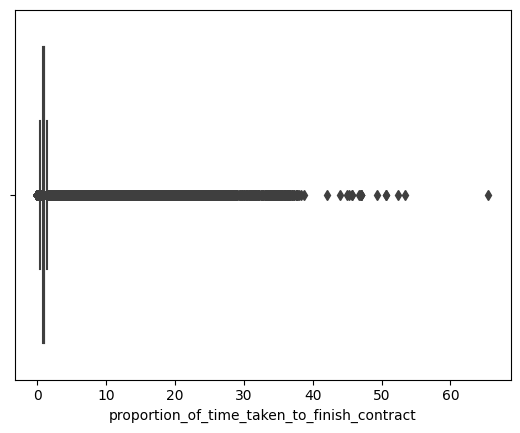

In [240]:
sns.boxplot(data=credit_bureau_a_1_df[credit_bureau_a_1_df.month_lapse_between_start_and_end_date_of_closed_contract>1], x="proportion_of_time_taken_to_finish_contract")

## 8. debtoutstand_525A

In [243]:
get_column_description(feature_df, "debtoutstand_525A")

'Outstanding amount of existing contract.'

In [247]:
credit_bureau_a_1_df.debtoutstand_525A.isnull().value_counts()

debtoutstand_525A
True     14554700
False     1385837
Name: count, dtype: int64

In [244]:
get_column_description(feature_df, "debtoverdue_47A")

"Amount that is currently past due on a client's existing credit contract."

In [259]:
credit_bureau_a_1_df[~credit_bureau_a_1_df.debtoutstand_525A.isnull()].sort_values(by=["num_group1"])[["num_group1", "generated_has_active_contract", "generated_has_closed_contract", "generated_closed_contract_end_type", "contractst_964M", "classificationofcontr_400M", "dateofcredstart_181D", "dateofcredend_353D", "dateofrealrepmt_138D", "month_lapse_between_start_and_real_end_date_of_closed_contract", "month_lapse_between_start_and_end_date_of_closed_contract", "proportion_of_time_taken_to_finish_contract", "debtoutstand_525A"]].tail()

,num_group1,generated_has_active_contract,generated_has_closed_contract,generated_closed_contract_end_type,contractst_964M,classificationofcontr_400M,dateofcredstart_181D,dateofcredend_353D,dateofrealrepmt_138D,month_lapse_between_start_and_real_end_date_of_closed_contract,month_lapse_between_start_and_end_date_of_closed_contract,proportion_of_time_taken_to_finish_contract,debtoutstand_525A
10607940,1,0,1,before_end_date,7241344e,ea6782cc,2019-03-12,2019-09-20,2019-09-11,6.0,7.0,0.857143,44957.16
10606663,1,0,0,NaN,a55475b1,a55475b1,NaT,NaT,NaT,NaN,NaN,NaN,1630702.80
10818227,1,1,1,before_end_date,7241344e,ea6782cc,2013-08-20,2019-08-20,2019-05-18,68.0,71.0,0.957746,899535.10
13485817,1,0,0,NaN,a55475b1,a55475b1,NaT,NaT,NaT,NaN,NaN,NaN,82644.39
10743626,1,1,1,before_end_date,7241344e,01f63ac8,2018-03-05,2022-03-05,2019-04-30,14.0,48.0,0.291667,546310.94


## 9. description_351M

In [261]:
get_column_description(feature_df, "description_351M")

'Categorization of clients by credit bureau.'

In [262]:
credit_bureau_a_1_df.description_351M.isnull().value_counts()

description_351M
False    15940537
Name: count, dtype: int64

In [263]:
credit_bureau_a_1_df.description_351M.value_counts()

description_351M
a55475b1    15878544
6da7c7ed       14573
95decc86       10032
f8e51f8d        6885
53179c19        6599
0349102c        6501
1d89fa48        6326
18e98e64        5547
8a7423d5        2711
0cb4d552        1960
0bfbf8f5         833
153cfa61          26
Name: count, dtype: int64

In [271]:
statistics_description_351M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_description_351M_nunique=pd.NamedAgg(column="description_351M", aggfunc="nunique"), generated_description_351M_mode=pd.NamedAgg(column="description_351M", aggfunc=lambda x:most_common_value(x, ignore_category="")))

In [274]:
merged_train_base_statistics_description_351M_for_case_id_df = train_base_df.merge(statistics_description_351M_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_description_351M_for_case_id_df: {merged_train_base_statistics_description_351M_for_case_id_df.shape}")

Shape of merged_train_base_statistics_description_351M_for_case_id_df: (1526659, 7)


In [276]:
percent_default_for_generated_description_351M_mode_df = get_percent_of_column(merged_train_base_statistics_description_351M_for_case_id_df, "generated_description_351M_mode", "target")

/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_6806/3811779417.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  bar_plot.show()


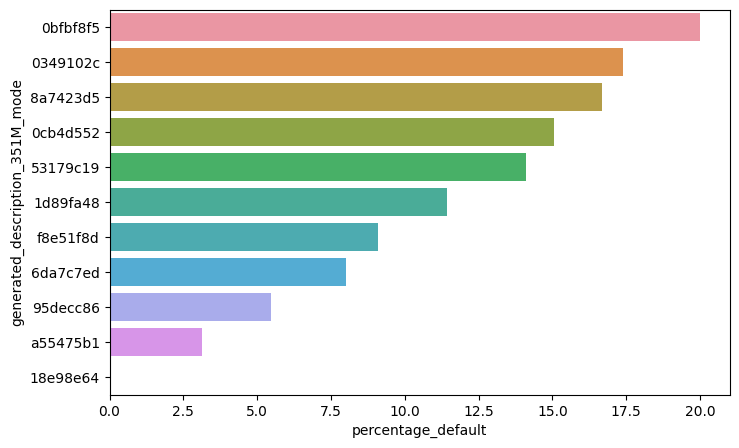

In [279]:
bar_plot = plot_barplot(percent_default_for_generated_description_351M_mode_df, "percentage_default", "generated_description_351M_mode")
bar_plot.show()

In [280]:
percent_default_for_generated_description_351M_mode_df

,generated_description_351M_mode,target,total_rows,percentage_default
0,0349102c,4,23,17.391304
1,0bfbf8f5,3,15,20.000000
2,0cb4d552,11,73,15.068493
3,18e98e64,0,20,0.000000
4,1d89fa48,4,35,11.428571
5,53179c19,34,241,14.107884
6,6da7c7ed,2,25,8.000000
7,8a7423d5,3,18,16.666667
8,95decc86,3,55,5.454545
9,a55475b1,43390,1385691,3.131290


## 10. dpdmax_139P and dpdmax_757P

In [281]:
get_column_description(feature_df, "dpdmax_139P")

'Maximal days past due for active contract.'

In [282]:
get_column_description(feature_df, "dpdmax_757P")

'Maximum days past due for a closed contract.'

In [285]:
# def statistics_dpd(series):
#     early_payment_series = series[series<=0]
#     late_payment_series = series[series>0]
#     if len(early_payment_series) != 0:
#         max_early_payment = early_payment_series.min()
#         min_early_payment = early_payment_series.max()
#     else:
#         max_early_payment = np.nan
#         min_early_payment = np.nan

#     if len(early_payment_series) !=0:
#         max_late_payment = early_payment_series.max()
#         min_late_payment = early_payment_series.min()
#     else:
#         max_late_payment = np.nan
#         min_late_payment = np.nan

#     return pd.Series([max_early_payment, min_early_payment, max_late_payment, min_late_payment])

## 11. financialinstitution_382M and financialinstitution_591M

In [287]:
get_column_description(feature_df, "financialinstitution_382M")

'Name of financial institution that is linked to a closed contract.'

In [288]:
get_column_description(feature_df, "financialinstitution_591M")

'Financial institution name of the active contract.'

In [302]:
statistics_financialinstitution_382M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_financialinstitution_382M_nunique=pd.NamedAgg(column="financialinstitution_382M", aggfunc="nunique"), generated_financialinstitution_382M_mode=pd.NamedAgg(column="financialinstitution_382M", aggfunc=lambda x:most_common_value(x, ignore_category=""))).reset_index()

In [303]:
statistics_financialinstitution_591M_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg(generated_financialinstitution_591M_nunique=pd.NamedAgg(column="financialinstitution_591M", aggfunc="nunique"), generated_financialinstitution_591M_mode=pd.NamedAgg(column="financialinstitution_591M", aggfunc=lambda x:most_common_value(x, ignore_category=""))).reset_index()

In [304]:
statistics_financialinstitution_for_case_id_df = statistics_financialinstitution_382M_for_case_id_df.merge(statistics_financialinstitution_591M_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="outer")

In [306]:
statistics_financialinstitution_for_case_id_df[(statistics_financialinstitution_for_case_id_df.generated_financialinstitution_382M_mode != "a55475b1") & (statistics_financialinstitution_for_case_id_df.generated_financialinstitution_591M_mode != "a55475b1")]

,case_id,generated_financialinstitution_382M_nunique,generated_financialinstitution_382M_mode,generated_financialinstitution_591M_nunique,generated_financialinstitution_591M_mode
127174,188648,5,P102_97_118,2,P102_97_118
270055,707688,4,P204_66_73,3,P102_97_118
310810,756122,2,6ac884b8,2,P102_97_118
322745,770312,4,50babcd4,2,P150_136_157
491453,967915,2,d6a7d943,5,d6a7d943


## 12. instlamount_768A and instlamount_852A

In [307]:
get_column_description(feature_df, "instlamount_768A")

'Instalment amount for the active contract in credit bureau.'

In [308]:
get_column_description(feature_df, "instlamount_852A")

'Instalment amount for closed contract.'

In [336]:
statistics_instlamount_768A_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"instlamount_768A": ["max", "min", "mean", "count"]}).reset_index()
statistics_instlamount_768A_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_instlamount_768A_for_case_id_df.columns]

In [337]:
statistics_instlamount_852A_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"instlamount_852A": ["max", "min", "mean", "count"]}).reset_index()
statistics_instlamount_852A_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_instlamount_852A_for_case_id_df.columns]

In [338]:
statistics_instlamount_for_case_id_df = statistics_instlamount_768A_for_case_id_df.merge(statistics_instlamount_852A_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="outer")

In [339]:
merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df = train_base_df.merge(statistics_instlamount_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df: {merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df.shape}")

Shape of merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df: (1526659, 13)


<Axes: xlabel='target', ylabel='generated_instlamount_768A_max'>

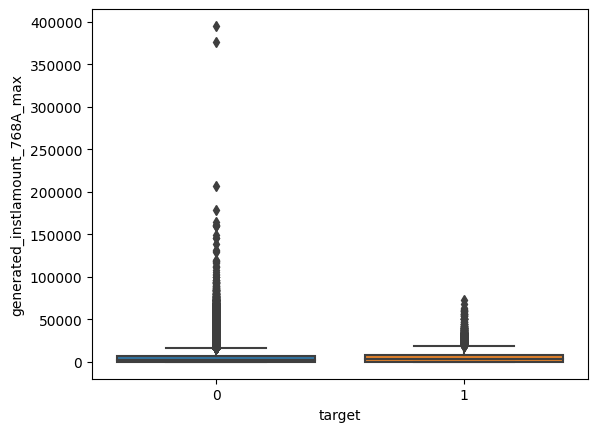

In [340]:
sns.boxplot(data=merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df, y="generated_instlamount_768A_max", x="target")

<Axes: xlabel='target', ylabel='generated_instlamount_852A_max'>

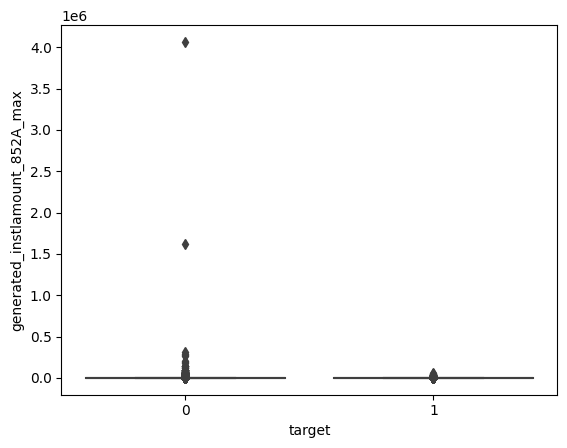

In [341]:
sns.boxplot(data=merged_train_base_statistics_instlamount_for_case_id_df_for_case_id_df, y="generated_instlamount_852A_max", x="target")

In [327]:
#plot_scatterplot(merged_train_base_statistics_financialinstitution_for_case_id_df, "generated_instlamount_768A_max", "generated_instlamount_852A_max", show_x_y_line=False)

In [ ]:
## target=0 has higher max instalment amount for active and closed contracts

## 13. interestrate_508L

In [328]:
get_column_description(feature_df, "interestrate_508L")

'Interest rate for a closed contract in the credit bureau.'

## 14. monthlyinstlamount_332A and monthlyinstlamount_674A

In [330]:
get_column_description(feature_df, "monthlyinstlamount_332A")

'Monthly instalment amount for active contract.'

In [331]:
get_column_description(feature_df, "monthlyinstlamount_674A")

'Monthly amount of instalment payment on a closed contract.'

In [334]:
statistics_monthlyinstlamount_332A_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"monthlyinstlamount_332A": ["max", "min", "mean", "count"]}).reset_index()
statistics_monthlyinstlamount_332A_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_monthlyinstlamount_332A_for_case_id_df.columns]

In [335]:
statistics_monthlyinstlamount_674A_for_case_id_df = credit_bureau_a_1_df.groupby(by=["case_id"]).agg({"monthlyinstlamount_674A": ["max", "min", "mean", "count"]}).reset_index()
statistics_monthlyinstlamount_674A_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_monthlyinstlamount_674A_for_case_id_df.columns]

In [342]:
statistics_monthlyinstlamount_for_case_id_df = statistics_monthlyinstlamount_332A_for_case_id_df.merge(statistics_monthlyinstlamount_674A_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="outer")

In [343]:
merged_train_base_statistics_monthlyinstlamount_for_case_id_df = train_base_df.merge(statistics_monthlyinstlamount_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_monthlyinstlamount_for_case_id_df: {merged_train_base_statistics_monthlyinstlamount_for_case_id_df.shape}")

Shape of merged_train_base_statistics_monthlyinstlamount_for_case_id_df: (1526659, 13)


<Axes: xlabel='target', ylabel='generated_monthlyinstlamount_332A_max'>

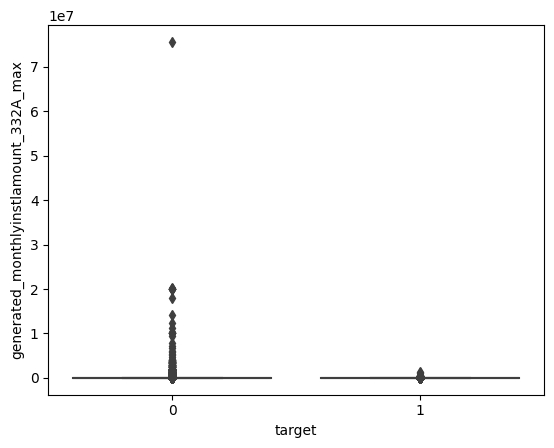

In [345]:
sns.boxplot(data=merged_train_base_statistics_monthlyinstlamount_for_case_id_df, y="generated_monthlyinstlamount_332A_max", x="target")

<Axes: xlabel='target', ylabel='generated_monthlyinstlamount_674A_max'>

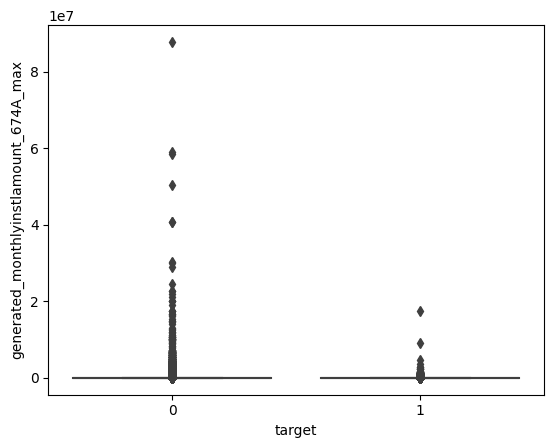

In [346]:
sns.boxplot(data=merged_train_base_statistics_monthlyinstlamount_for_case_id_df, y="generated_monthlyinstlamount_674A_max", x="target")

In [350]:
#plot_scatterplot(credit_bureau_a_1_df, "instlamount_768A", "monthlyinstlamount_332A", show_x_y_line=False)

### 1. processingdate_168D

In [ ]:
get_column_description(feature_df, "processingdate_168D")

In [ ]:
tax_registry_c_1_df.processingdate_168D.isnull().value_counts()

In [ ]:
## Check across how unique dates are tax deduction records for a given case_id
statistics_processingdate_168D_for_case_id_df = tax_registry_c_1_df.groupby(by=["case_id"]).agg({"processingdate_168D": ["nunique", "max"]}).reset_index()
statistics_processingdate_168D_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_processingdate_168D_for_case_id_df.columns]

In [ ]:
statistics_processingdate_168D_for_case_id_df.head(2)

In [ ]:
print(f"Minimum number of unique dates associated with case_id: {statistics_processingdate_168D_for_case_id_df['generated_processingdate_168D_nunique'].min()}")
print(f"Maximum number of unique dates associated with case_id: {statistics_processingdate_168D_for_case_id_df['generated_processingdate_168D_nunique'].max()}")

In [351]:
#plot_scatterplot(credit_bureau_a_1_df, "instlamount_852A", "monthlyinstlamount_674A", show_x_y_line=False)

## 15. numberofcontrsvalue_258L and numberofcontrsvalue_358L

In [375]:
get_column_description(feature_df, "numberofcontrsvalue_258L")

'Number of active contracts in credit bureau.'

In [353]:
get_column_description(feature_df, "numberofcontrsvalue_358L")

'Number of closed credit contracts.'

In [367]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"], ascending=True)[["lastupdate_1112D", "dateofcredstart_739D", "dateofcredend_289D", "numberofcontrsvalue_258L"]]

,lastupdate_1112D,dateofcredstart_739D,dateofcredend_289D,numberofcontrsvalue_258L
3577303,2019-02-21,2018-05-02,2023-05-02,3.0
3577302,2019-02-12,2018-05-18,2020-05-18,NaN
3577301,2019-02-09,2018-10-12,2020-10-12,NaN
3577304,None,NaT,NaT,NaN
3577305,None,NaT,NaT,NaN
3577306,None,NaT,NaT,NaN
3577307,None,NaT,NaT,NaN
3577308,None,NaT,NaT,NaN
3577309,None,NaT,NaT,NaN
3577310,None,NaT,NaT,NaN


In [371]:
credit_bureau_a_1_df[credit_bureau_a_1_df.case_id == random.choice(credit_bureau_a_1_df.case_id.unique())].sort_values(by=["num_group1"], ascending=True)[["lastupdate_388D", "dateofcredstart_181D", "dateofcredend_353D", "dateofrealrepmt_138D", "numberofcontrsvalue_358L"]]

,lastupdate_388D,dateofcredstart_181D,dateofcredend_353D,dateofrealrepmt_138D,numberofcontrsvalue_358L
7393361,2017-05-25,2015-04-13,2016-04-15,2016-04-15,11.0
7393362,2018-01-16,2016-04-11,2017-01-15,2017-01-15,NaN
7393359,2017-03-19,2016-09-28,2017-04-14,2017-03-19,NaN
7393367,2017-11-23,2017-04-28,2022-04-24,2017-11-21,NaN
7393364,2019-01-01,2017-06-03,2018-06-15,2018-06-15,NaN
7393360,2019-01-08,2017-08-10,2019-06-14,2019-01-08,NaN
7393366,2018-08-10,2017-11-21,2022-05-21,2018-08-10,NaN
7393365,2019-01-09,2017-11-29,2018-11-29,2018-11-29,NaN
7393363,2018-12-11,2018-03-12,2018-12-10,2018-12-11,NaN
7393357,2019-08-06,2018-07-20,2019-08-03,2019-08-03,NaN


## 15. numberofinstls_229L and numberofinstls_320L

In [372]:
get_column_description(feature_df, "numberofinstls_229L")

'Number of instalments on closed contract.'

In [373]:
get_column_description(feature_df, "numberofinstls_320L")

'Number of instalments of the active contract.'

In [354]:
credit_bureau_a_1_df.numberofcontrsvalue_258L.value_counts()

numberofcontrsvalue_258L
1.0     513114
2.0     421487
3.0     233551
4.0      96311
5.0      26296
6.0       7740
0.0       3489
7.0       2092
8.0        553
9.0        166
10.0        67
11.0        45
12.0        27
13.0        16
14.0         8
15.0         6
19.0         5
17.0         4
32.0         3
16.0         3
20.0         3
46.0         2
99.0         1
60.0         1
28.0         1
71.0         1
92.0         1
56.0         1
83.0         1
22.0         1
50.0         1
44.0         1
18.0         1
24.0         1
35.0         1
27.0         1
21.0         1
Name: count, dtype: int64